In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split
import pickle

plt.style.use('fivethirtyeight')

In [2]:
train_path = "../input/amazon-cleaned-reviews/train.csv"
test_path = "../input/amazon-cleaned-reviews/test.csv"
tokenizer_path = "../input/amazon-cleaned-reviews/tokenizer.pkl"

In [3]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

train.head()

,text,target
0,stuning even for the non gamer this sound trac...,1
1,the best soundtrack ever to anything i am read...,1
2,amazing this soundtrack is my favorite music o...,1
3,excellent soundtrack i truly like this soundtr...,1
4,remember pull your jaw off the floor after hea...,1


In [4]:
MAX_FEATURES = 12000

tokenizer = pickle.load(open(tokenizer_path, "rb"))

train_tokens = tokenizer.texts_to_sequences(train['text'].values)
test_tokens = tokenizer.texts_to_sequences(test['text'].values)

In [5]:
train_text, val_text, train_target, val_target = train_test_split(train_tokens, train['target'], test_size=0.2, random_state=42, stratify= train['target'])

train_data = tf.data.Dataset.from_tensor_slices((tf.ragged.constant(train_text), train_target)).batch(128)
val_data = tf.data.Dataset.from_tensor_slices((tf.ragged.constant(val_text), val_target)).batch(128)
test_data = tf.data.Dataset.from_tensor_slices((tf.ragged.constant(test_tokens), test['target'])).batch(128)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [6]:
def get_callbacks(file_path):
    return [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.3, patience=1, min_lr=0.00001),
        tf.keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='val_loss', mode='min', save_best_only=True),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, min_delta=1e-8, patience=3)
    ]

In [7]:
def plot_history(history):
    get_plot_data = lambda metric: [np.arange(len(metric)) + 1, metric]

    plt.figure(figsize=(10,5))

    plt.plot(*get_plot_data(history.history['loss']))
    plt.plot(*get_plot_data(history.history['accuracy']))
    plt.plot(*get_plot_data(history.history['val_loss']))
    plt.plot(*get_plot_data(history.history['val_accuracy']))

    plt.title('Model performance')
    plt.legend(list(history.history.keys())[:-1])
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.show()

In [8]:
def plot_confmat(y_true, predictions):
    labels = ['negative', 'positive']

    conf_mat = confusion_matrix(y_true, predictions, normalize='true')

    plt.figure(figsize=(8,5))
    sns.heatmap(pd.DataFrame(conf_mat, columns=labels, index=labels), annot=True, fmt='.2f')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix of test data')
    plt.show()

In [9]:
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(train['target']), y=train['target'])
class_weight = dict(enumerate(class_weight))

In [10]:
LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None], dtype=tf.int32, ragged=True),
    tf.keras.layers.Embedding(MAX_FEATURES, 128),
    tf.keras.layers.LSTM(2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
LSTM_history = LSTM_model.fit(train_data, epochs=15, validation_data=val_data, callbacks=get_callbacks('LSTM_model.h5'), class_weight=class_weight)

2021-12-25 11:55:08.887804: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/lstm/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/lstm/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/lstm/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


313/313 [==============================] - 65s 199ms/step - loss: 0.5686 - accuracy: 0.7753 - val_loss: 0.4718 - val_accuracy: 0.8395
Epoch 2/15
313/313 [==============================] - 62s 197ms/step - loss: 0.4432 - accuracy: 0.8404 - val_loss: 0.4263 - val_accuracy: 0.8449
Epoch 3/15
313/313 [==============================] - 62s 199ms/step - loss: 0.3609 - accuracy: 0.8777 - val_loss: 0.3831 - val_accuracy: 0.8606
Epoch 4/15
313/313 [==============================] - 63s 202ms/step - loss: 0.3244 - accuracy: 0.8889 - val_loss: 0.3852 - val_accuracy: 0.8550
Epoch 5/15
313/313 [==============================] - 63s 201ms/step - loss: 0.2802 - accuracy: 0.9088 - val_loss: 0.3741 - val_accuracy: 0.8606
Epoch 6/15
313/313 [==============================] - 62s 199ms/step - loss: 0.2595 - accuracy: 0.9188 - val_loss: 0.3707 - val_accuracy: 0.8645
Epoch 7/15
313/313 [==============================] - 62s 199ms/step - loss: 0.2424 - accuracy: 0.9255 - val_loss: 0.3685 - val_accuracy: 0.8

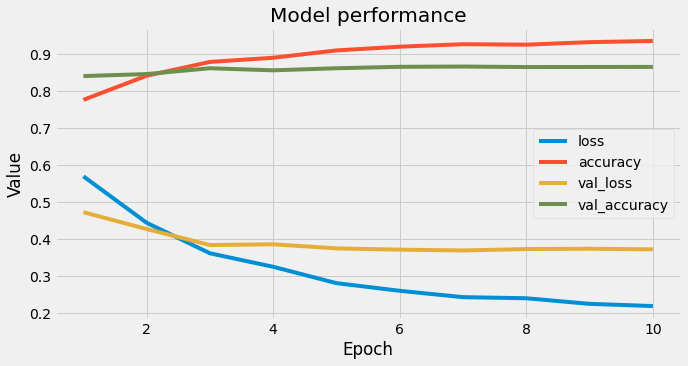

In [12]:
plot_history(LSTM_history)

In [13]:
LSTM_model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None], dtype=tf.int32, ragged=True),
    tf.keras.layers.Embedding(MAX_FEATURES, 128),
    tf.keras.layers.LSTM(2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

LSTM_model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
LSTM2_history = LSTM_model2.fit(train_data, epochs=15, validation_data=val_data, callbacks=get_callbacks('LSTM_model2.h5'), class_weight=class_weight)

Epoch 1/15


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/lstm_1/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/lstm_1/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_1/lstm_1/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


313/313 [==============================] - 65s 199ms/step - loss: 0.5526 - accuracy: 0.8184 - val_loss: 0.4744 - val_accuracy: 0.8529
Epoch 2/15
313/313 [==============================] - 61s 196ms/step - loss: 0.4278 - accuracy: 0.8607 - val_loss: 0.3932 - val_accuracy: 0.8686
Epoch 3/15
313/313 [==============================] - 61s 195ms/step - loss: 0.3286 - accuracy: 0.8958 - val_loss: 0.3285 - val_accuracy: 0.8844
Epoch 4/15
313/313 [==============================] - 62s 197ms/step - loss: 0.2638 - accuracy: 0.9137 - val_loss: 0.3103 - val_accuracy: 0.8830
Epoch 5/15
313/313 [==============================] - 60s 193ms/step - loss: 0.2227 - accuracy: 0.9276 - val_loss: 0.3021 - val_accuracy: 0.8872
Epoch 6/15
313/313 [==============================] - 62s 197ms/step - loss: 0.1987 - accuracy: 0.9352 - val_loss: 0.3118 - val_accuracy: 0.8816
Epoch 7/15
313/313 [==============================] - 60s 191ms/step - loss: 0.1655 - accuracy: 0.9480 - val_loss: 0.3062 - val_accuracy: 0.8

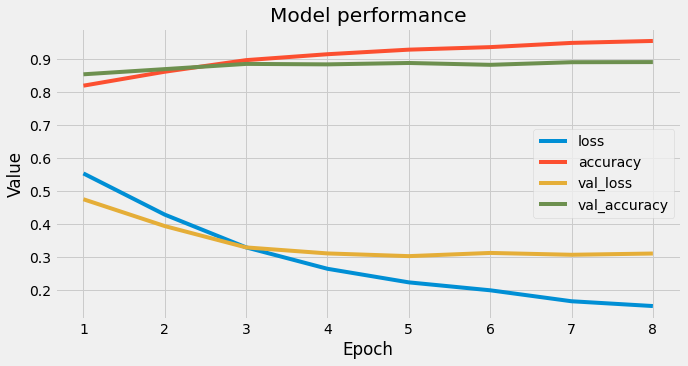

In [15]:
plot_history(LSTM2_history)

In [18]:
best_model = tf.keras.models.load_model("./LSTM_model2.h5")

predictions = best_model.predict(test_data)
y_true = test['target']
print("ROC AUC score on test set: {0:.4}".format(roc_auc_score(y_true, predictions)))

fpr, tpr, thresholds = roc_curve(y_true, predictions)
optimal_threshold = thresholds[np.argmax(tpr-fpr, axis=0)]
print("Optimal threshold on test set: {0:.4}".format(optimal_threshold))

ROC AUC score on test set: 0.9365
Optimal threshold on test set: 0.6253


In [19]:
print(classification_report(y_true, predictions >= optimal_threshold))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2435
           1       0.89      0.88      0.88      2565

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



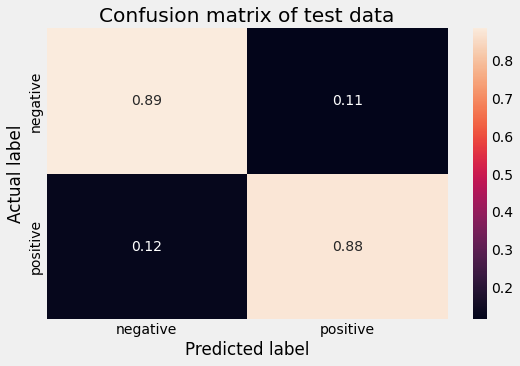

In [20]:
plot_confmat(y_true, predictions >= optimal_threshold)

In [68]:
best_model.predict(
    tf.ragged.constant(
        tokenizer.texts_to_sequences([
            "it s begin to look a lot like xmas, snow everywhere",
            "so inappropriate i will go some where else that is more suitable"
        ])
    )
)

array([[0.8191339 ],
       [0.08598205]], dtype=float32)